# Image Captioning

neural networks to generate captions for an image using CNN as Encoder and RNN(LSTM) as Decoder
Image captioning is the process of generating text description of an image. It uses Natural Language Processing and Computer Vision to generate the captions.

The model architechture consists of CNN(Resnet50) and RNN(LSTM). the RNN can be Vanilla, LSTM or GRU. The Resnet50 extracts features from the image and then get them fed to the RNN. The word embeddings are used as input to the RNN. with the embedded image feature vector and the embedded word vector, the RNN generates one word at each time step. 

# Dataset

The Microsoft Common Objects in COntext(COCO) dataset is a large-scale dataset for scene understanding. The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.

read more about the dataset on the website: http://cocodataset.org/#home
or in the research paper:
https://arxiv.org/pdf/1405.0312.pdf

In [117]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),
                                                   (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


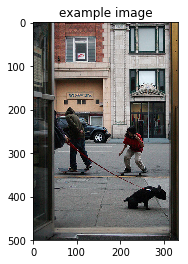

In [142]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


orig_image, image = next(iter(data_loader))
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [119]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [143]:
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.to(device), decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(EncoderCNN(
   (resnet): Sequential(
     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace)
     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (4): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace)
         (downsample): Sequential(
           (0): Co

In [121]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
output = decoder.sample(features)
print('example output:', output)
assert (type(output)==list), "Python list" 
assert all([type(x)==int for x in output]), "list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "integer that indicates a token in the vocabulary."

example output: [0, 3, 858, 130, 942, 111, 3, 858, 859, 18, 1]


In [122]:
def clean_sentence(output):
    start_word = data_loader.dataset.vocab(data_loader.dataset.vocab.start_word)
    end_word = data_loader.dataset.vocab(data_loader.dataset.vocab.end_word)
    
    res = ''
    count = 0
    for x in output:
        if x != start_word and x != end_word :
            res+= data_loader.dataset.vocab.idx2word[x] + ' '
    return res

In [123]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Python string'

example sentence: a train is stopped at a train station . 


In [162]:
import matplotlib.pyplot as plt
import cv2
def prediction():
    '''
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)   
    '''
    
    image = plt.imread('son.jpg')
    plt.imshow(image)
    image = image / 255.0
    image = cv2.resize(image, (224, 224))
    image = image.reshape(224, 224, -1)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    image.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image = image.cuda()
        
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    print(sentence)

a man holding a cell phone up to his ear . 


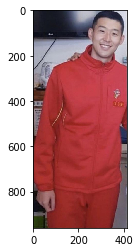

In [163]:
prediction()